In [2]:
from transformers import BertTokenizerFast, BertForQuestionAnswering, pipeline, \
                          DataCollatorWithPadding, TrainingArguments, Trainer, \
                          AutoModelForQuestionAnswering, AutoTokenizer
from datasets import Dataset, load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import torch
import gc

In [3]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased', return_token_type_ids=True)
qa_bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-large-uncased

In [4]:
qa_dataset = load_dataset('adversarial_qa', 'adversarialQA')
qa_dataset

Found cached dataset adversarial_qa (/root/.cache/huggingface/datasets/adversarial_qa/adversarialQA/1.0.0/92356be07b087c5c6a543138757828b8d61ca34de8a87807d40bbc0e6c68f04b)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'metadata'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'metadata'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'metadata'],
        num_rows: 3000
    })
})

In [5]:
qa_dataset['train']

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'metadata'],
    num_rows: 30000
})

In [6]:
def preprocess(data):
    return bert_tokenizer(data['question'], data['context'], truncation=True)
qa_dataset = qa_dataset.map(preprocess, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/adversarial_qa/adversarialQA/1.0.0/92356be07b087c5c6a543138757828b8d61ca34de8a87807d40bbc0e6c68f04b/cache-fec5c37c37ce835c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/adversarial_qa/adversarialQA/1.0.0/92356be07b087c5c6a543138757828b8d61ca34de8a87807d40bbc0e6c68f04b/cache-601deda5d8629c30.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/adversarial_qa/adversarialQA/1.0.0/92356be07b087c5c6a543138757828b8d61ca34de8a87807d40bbc0e6c68f04b/cache-a6608866aa712393.arrow


In [ ]:
qa_dataset

In [7]:
for name, param in qa_bert.bert.named_parameters():
    if 'encoder.layer.22' in name:
        break
    param.requires_grad = False

In [8]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
batch_size = 16
epochs = 3
training_args = TrainingArguments(
    output_dir='qa/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='qa/logs',
    save_strategy='epoch',
    logging_steps=10,
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)
trainer = Trainer(
    model=qa_bert,
    args=training_args,
    train_dataset=qa_dataset['train'],
    eval_dataset=qa_dataset['test'],
    data_collator=data_collator
)

In [ ]:
trainer.evaluate()

In [ ]:
trainer.train()

In [9]:
pipe = pipeline('question-answering', 'bert-large-uncased', tokenizer=bert_tokenizer)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-large-uncased

In [10]:
pipe('Where is Sunggon living these days?', 'Sunggon lives in Tokyo, Japan')

{'score': 0.02581571228802204, 'start': 17, 'end': 23, 'answer': 'Tokyo,'}

In [18]:
BeautifulSoup(requests.get(f'https://www.google.com/search?q={PERSON}&hl=en').text).get_text()[:512]

'Sinan Ozdemir - Google SearchGoogle×Please click here if you are not redirected within a few seconds.    AllNewsImagesVideos Maps Shopping Books Search tools    Any timeAny timePast hourPast 24 hoursPast weekPast monthPast yearAll resultsAll resultsVerbatimSinan OzdemirAuthorSinan Ozdemir is a data scientist, start-up founder, and educator living in the San Francisco Bay Area. He studied pure mathematics at the Johns Hopkins University. ... Google BooksBooksPrinciples of Data Science2016Hands-On Machine Lea'

In [19]:
PERSON = 'Sinan Ozdemir'
google_html = BeautifulSoup(requests.get(f'https://www.google.com/search?q={PERSON}&hl=en').text).get_text()[:512]

pipe(f'Who is {PERSON}?', google_html)

{'score': 0.00015605907537974417,
 'start': 263,
 'end': 309,
 'answer': 'OzdemirAuthorSinan Ozdemir is a data scientist'}

In [20]:
squad_pipe = pipeline('question-answering', 'bert-large-uncased-whole-word-masking-finetuned-squad')

In [23]:
squad_pipe('Where is Sunggon living these days?', 'Sunggon lives in Saitama, Japan but Changmin lives in Seoul, Korea')

{'score': 0.9564394354820251,
 'start': 17,
 'end': 31,
 'answer': 'Saitama, Japan'}

In [24]:
squad_pipe('Where is Changmin living these days?', 'Sunggon lives in Saitama, Japan but Changmin lives in Seoul, Korea')

{'score': 0.9545416235923767, 'start': 54, 'end': 66, 'answer': 'Seoul, Korea'}

In [25]:
large_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
qa_input = large_tokenizer(
    'Where is Sunggon living these days?', 'Sunggon lives in Saitama, Japan but Changmin lives in Seoul, Korea',
    return_tensors='pt'
)
qa_input

{'input_ids': tensor([[  101,  2073,  2003,  7042,  7446,  2542,  2122,  2420,  1029,   102,
          7042,  7446,  3268,  1999, 18952, 28282,  1010,  2900,  2021, 11132,
         10020,  3268,  1999, 10884,  1010,  4420,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])}

In [26]:
large_qa_bert = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
output = large_qa_bert(**qa_input)
output

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-5.7107, -6.3289, -7.8057, -6.1112, -8.0977, -6.7567, -6.8568, -8.3265,
         -8.8925, -5.7105,  2.2716, -2.3515, -1.2024,  1.3121,  6.7357, -1.5773,
         -4.5230,  1.7059, -5.5010, -2.0386, -6.0576, -5.5499, -5.0557, -0.3713,
         -6.4189, -2.6846, -5.7105]], grad_fn=<CloneBackward0>), end_logits=tensor([[-0.7425, -6.6148, -6.5965, -7.8024, -5.6677, -6.9190, -6.6665, -5.5354,
         -6.6281, -0.7423, -5.2488, -4.1598, -5.1177, -4.3830, -2.4604,  3.7062,
         -0.1032,  7.6857, -0.4084, -5.8400, -3.6796, -5.8025, -6.3875, -1.2254,
         -4.3844,  0.6939, -0.7446]], grad_fn=<CloneBackward0>), hidden_states=None, attentions=None)

In [29]:
token_labels = large_tokenizer.convert_ids_to_tokens(qa_input['input_ids'].squeeze())
token_labels

['[CLS]',
 'where',
 'is',
 'sung',
 '##gon',
 'living',
 'these',
 'days',
 '?',
 '[SEP]',
 'sung',
 '##gon',
 'lives',
 'in',
 'sai',
 '##tama',
 ',',
 'japan',
 'but',
 'chang',
 '##min',
 'lives',
 'in',
 'seoul',
 ',',
 'korea',
 '[SEP]']

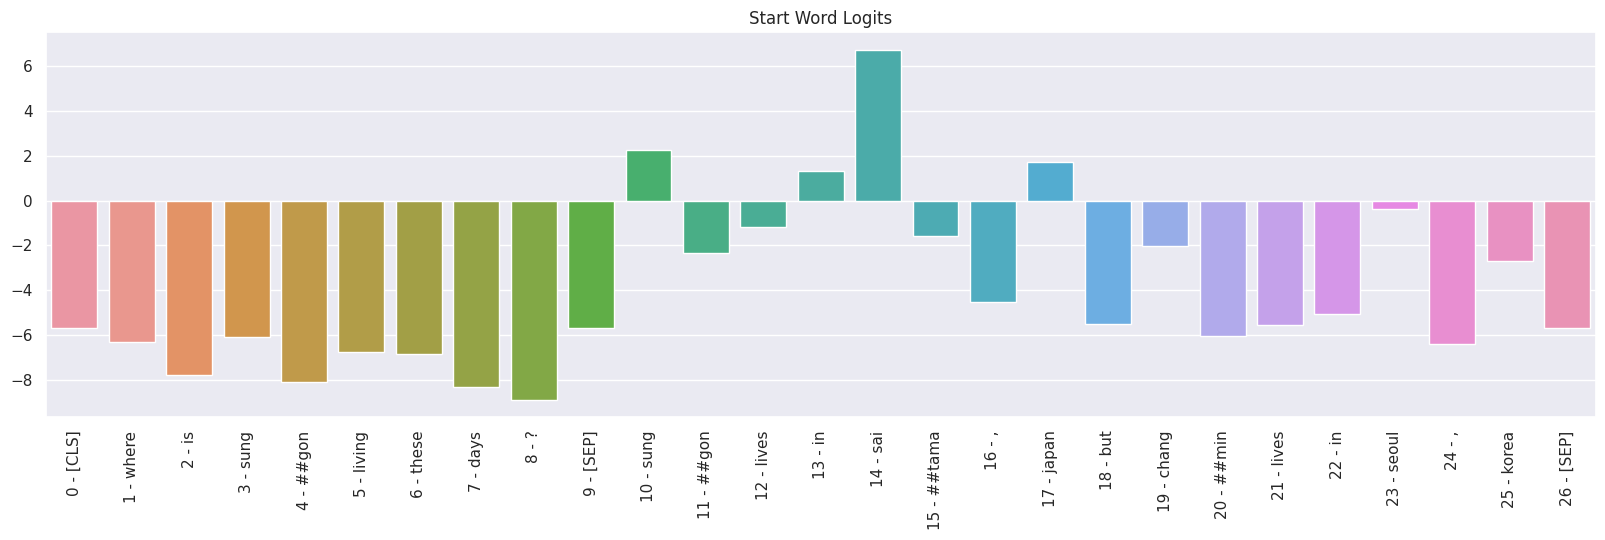

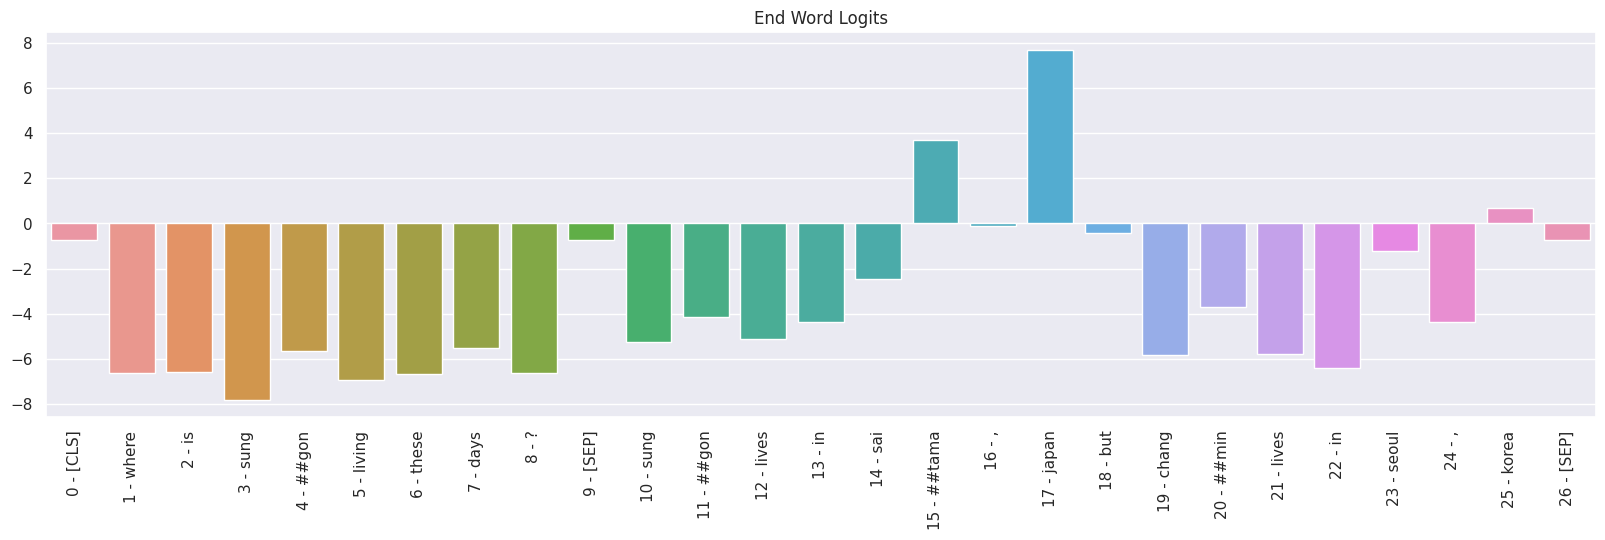

In [32]:
sns.set(rc={'figure.figsize': (20, 5)})
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), errorbar=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.title('Start Word Logits')
plt.show()
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), errorbar=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.title('End Word Logits')
plt.show()